# **Importing the necessary python libraries**




In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score




*   The dataset appears to represent ride-sharing metrics, including factors like loyalty status, ride duration, and historical cost.
*   The first few rows indicate a mix of categorical and numerical data.


In [55]:
data = pd.read_csv("ride_sharing.csv")
print(data.head())

   Number_of_Riders  Number_of_Drivers Location_Category  \
0                90                 45             Urban   
1                58                 39          Suburban   
2                42                 31             Rural   
3                89                 28             Rural   
4                78                 22             Rural   

  Customer_Loyalty_Status  Number_of_Past_Rides  Average_Ratings  \
0                  Silver                    13             4.47   
1                  Silver                    72             4.06   
2                  Silver                     0             3.99   
3                 Regular                    67             4.31   
4                 Regular                    74             3.77   

  Time_of_Booking Vehicle_Type  Expected_Ride_Duration  \
0           Night      Premium                      90   
1         Evening      Economy                      43   
2       Afternoon      Premium                      76  

# **Exploratory Data Analysis**

In [56]:
print(data.describe())

       Number_of_Riders  Number_of_Drivers  Number_of_Past_Rides  \
count       1000.000000        1000.000000           1000.000000   
mean          60.372000          27.076000             50.031000   
std           23.701506          19.068346             29.313774   
min           20.000000           5.000000              0.000000   
25%           40.000000          11.000000             25.000000   
50%           60.000000          22.000000             51.000000   
75%           81.000000          38.000000             75.000000   
max          100.000000          89.000000            100.000000   

       Average_Ratings  Expected_Ride_Duration  Historical_Cost_of_Ride  
count      1000.000000              1000.00000              1000.000000  
mean          4.257220                99.58800               372.502623  
std           0.435781                49.16545               187.158756  
min           3.500000                10.00000                25.993449  
25%           3.8

A scatter plot with a trendline is generated to visualize the relationship between Expected_Ride_Duration and Historical_Cost_of_Ride. The trendline indicates a correlation, aiding in understanding how ride duration impacts cost.

In [57]:
fig = px.scatter(data, x='Expected_Ride_Duration',
                 y='Historical_Cost_of_Ride',
                 title='Expected Ride Duration vs. Historical Cost of Ride',
                 trendline='ols')
fig.update_traces(marker=dict(color='steelblue'))
fig.show()

The Box Plot visualizes the distribution of Historical_Cost_of_Ride across different Vehicle_Type categories. It highlights the cost variance between vehicle types and identifies potential outliers.

In [58]:
fig = px.box(data, x='Vehicle_Type',
             y='Historical_Cost_of_Ride',
             title='Historical Cost of Ride Distribution by Vehicle Type')
fig.update_traces(marker_color='steelblue')
fig.show()

In [59]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=[float, int])

# Compute the correlation matrix
corr_matrix = numeric_data.corr()

# Create the heatmap
fig = go.Figure(data=go.Heatmap(z=corr_matrix.values,
                                x=corr_matrix.columns,
                                y=corr_matrix.columns,
                                colorscale='Viridis'))

# Update layout and show the plot
fig.update_layout(title='Correlation Matrix')
fig.show()

The heatmap highlights correlations among the key numerical variables in the dataset.

*    Expected_Ride_Duration and Historical_Cost_of_Ride show a very strong positive correlation (dark yellow), indicating longer rides consistently cost more.

*    Number_of_Riders and Number_of_Drivers have a moderate to strong positive correlation (yellow-green area), suggesting supply-demand matching.

*    Average_Ratings shows very weak correlations (purple) with most other variables, suggesting customer satisfaction isn't strongly tied to operational metrics.

*    Number_of_Past_Rides has minimal correlation with other variables, indicating rider history doesn't strongly influence current ride characteristics.

In [60]:
# Encoding categorical variables
data_encoded = pd.get_dummies(data, drop_first=True)

# Verify encoding
print(data_encoded.head())


   Number_of_Riders  Number_of_Drivers  Number_of_Past_Rides  Average_Ratings  \
0                90                 45                    13             4.47   
1                58                 39                    72             4.06   
2                42                 31                     0             3.99   
3                89                 28                    67             4.31   
4                78                 22                    74             3.77   

   Expected_Ride_Duration  Historical_Cost_of_Ride  \
0                      90               284.257273   
1                      43               173.874753   
2                      76               329.795469   
3                     134               470.201232   
4                     149               579.681422   

   Location_Category_Suburban  Location_Category_Urban  \
0                       False                     True   
1                        True                    False   
2             

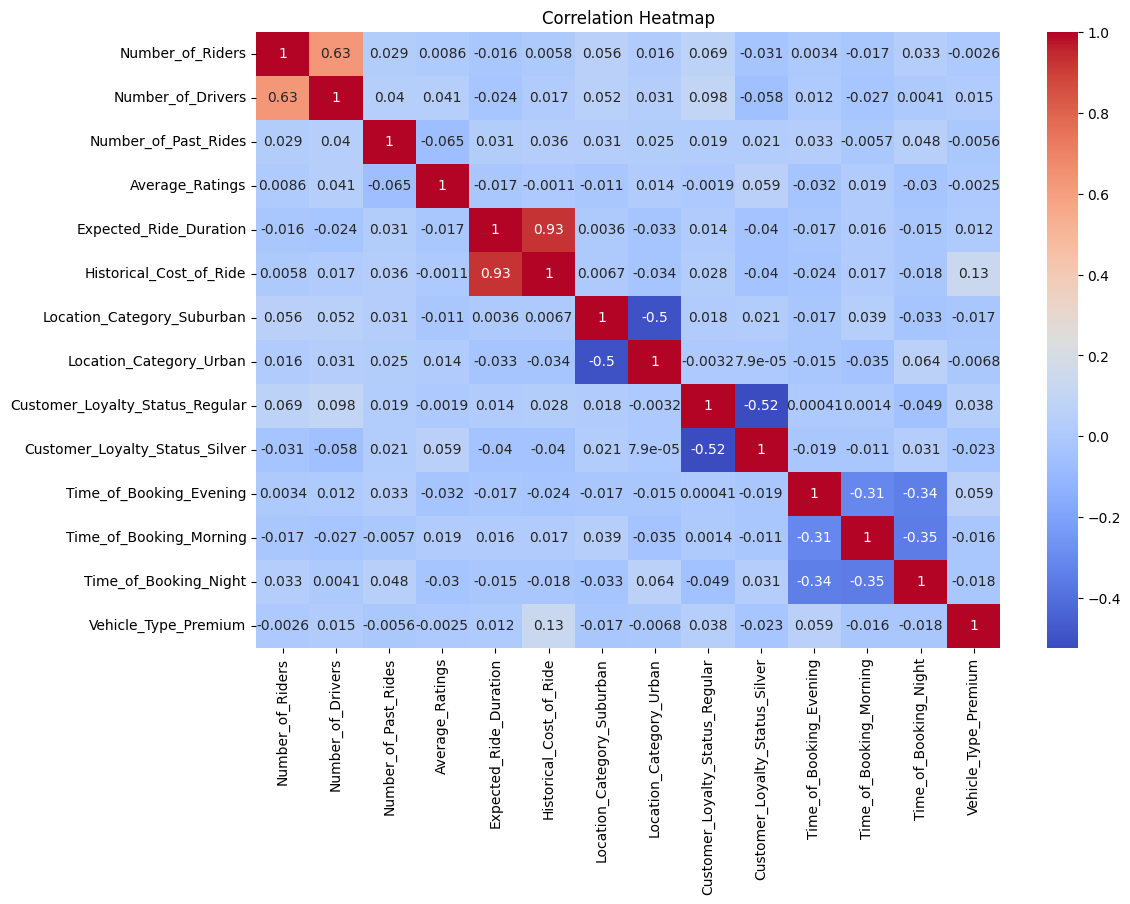

In [61]:
# Correlation Heatmap with encoded data
plt.figure(figsize=(12, 8))
sns.heatmap(data_encoded.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

The detailed heatmap incorporates not only numerical variables but also encoded categorical features like Location_Category and Customer_Loyalty_Status. It reveals correlations such as a strong relationship between Expected_Ride_Duration and Historical_Cost_of_Ride, while categorical variables like Location_Category_Urban exhibit negligible correlations with most numerical features, suggesting limited influence on the target variable.

**(i) Strong Correlations (|r| > 0.5):**
*   Expected_Ride_Duration and Historical_Cost_of_Ride have the strongest positive correlation (0.93), confirming the relationship seen in Image 1
*   Number_of_Riders and Number_of_Drivers show a moderate negative correlation (-0.63), suggesting an inverse relationship
*   Location_Category_Suburban and Location_Category_Urban have a negative correlation (-0.5), which is expected as they're mutually exclusive
*   Customer_Loyalty_Status_Regular and Customer_Loyalty_Status_Silver show negative correlation (-0.52), also expected due to mutual exclusivity

**(ii) Time-Related Correlations:**
*   Time_of_Booking variables (Evening, Morning, Night) show weak negative correlations with each other (-0.31 to -0.35)
*   Time of booking has minimal correlation with ride cost or duration (all correlations < |0.1|)

**(iii) Weak Correlations:**
*   Vehicle_Type_Premium shows very weak correlations with most variables (all < |0.2|)
*   Average_Ratings shows minimal correlation with all other variables (all < |0.1|)
*   Number_of_Past_Rides has weak correlations across all variables (all < |0.1|)

# **Implementing a Dynamic Pricing Strategy**

The implemented dynamic pricing strategy aims to optimize revenue by incorporating both demand (number of riders) and supply (number of drivers) factors, moving beyond the limited duration-based approach.
The solution uses percentile-based thresholds (75th and 25th percentiles) to identify high and low demand/supply situations, with price multipliers adjusting ride costs accordingly.
Price adjustment thresholds (0.8 to 1.2) ensure the dynamic pricing remains reasonable while still responding to market conditions, preventing extreme fluctuations that could alienate customers.

In [62]:
# Calculate demand_multiplier based on percentile for high and low demand
high_demand_percentile = 75
low_demand_percentile = 25

data['demand_multiplier'] = np.where(data['Number_of_Riders'] > np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], low_demand_percentile))

# Calculate supply_multiplier based on percentile for high and low supply
high_supply_percentile = 75
low_supply_percentile = 25

data['supply_multiplier'] = np.where(data['Number_of_Drivers'] > np.percentile(data['Number_of_Drivers'], low_supply_percentile),
                                     np.percentile(data['Number_of_Drivers'], high_supply_percentile) / data['Number_of_Drivers'],
                                     np.percentile(data['Number_of_Drivers'], low_supply_percentile) / data['Number_of_Drivers'])

# Define price adjustment factors for high and low demand/supply
demand_threshold_high = 1.2  # Higher demand threshold
demand_threshold_low = 0.8  # Lower demand threshold
supply_threshold_high = 0.8  # Higher supply threshold
supply_threshold_low = 1.2  # Lower supply threshold

# Calculate adjusted_ride_cost for dynamic pricing
data['adjusted_ride_cost'] = data['Historical_Cost_of_Ride'] * (
    np.maximum(data['demand_multiplier'], demand_threshold_low) *
    np.maximum(data['supply_multiplier'], supply_threshold_high)
)

***Above Code Insights:***

**(i) Demand Multiplier Calculation:**
*   Uses 75th and 25th percentiles as thresholds for high/low demand
*   When Number_of_Riders exceeds 75th percentile:
        * Multiplier = Current Riders / 75th percentile value
        * This increases prices during high demand
*   When Number_of_Riders is lower:
        * Multiplier = Current Riders / 25th percentile value
        * This reduces prices during low demand

**(ii) Supply Multiplier Calculation:**
*   Also uses 75th and 25th percentiles for driver supply thresholds
*   When Number_of_Drivers exceeds 25th percentile:
        * Multiplier = 75th percentile / Current Drivers
        * Fewer drivers leads to higher prices
*   When Number_of_Drivers is lower:
        * Multiplier = 25th percentile / Current Drivers
        * More drivers leads to lower prices

**(iii) Price Adjustment Thresholds:**
*   Demand thresholds:
        * High: 1.2 (20% maximum increase)
        * Low: 0.8 (20% maximum decrease)
*   Supply thresholds:
        * High: 0.8 (20% maximum decrease)
        * Low: 1.2 (20% maximum increase)
*   These thresholds prevent extreme price fluctuations

**Final Price Calculation:**
*   Combines Historical_Cost_of_Ride with both multipliers
*   Uses np.maximum() to ensure multipliers don't go below minimum thresholds
*   Formula: Historical_Cost × max(demand_multiplier, 0.8) × max(supply_multiplier, 0.8)

# **Profit Percentage**

In [63]:
# Calculate the count of profitable and loss rides
profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

# Create a donut chart to show the distribution of profitable and loss rides
labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_count, loss_count]

# Add custom colors
colors = ['#1f77b4', '#ff7f0e']  # Green for profit, red for loss

fig = go.Figure(
    data=[go.Pie(
        labels=labels,
        values=values,
        hole=0.4,
        marker=dict(colors=colors)  # Apply colors
    )]
)

fig.update_layout(title='Profitability of Rides (Dynamic Pricing vs. Historical Pricing)')
fig.show()


**(i) Formula Analysis:**
- Profit percentage calculation: ((adjusted_ride_cost - Historical_Cost_of_Ride) / Historical_Cost_of_Ride) * 100.
- This formula effectively measures the percentage increase/decrease from historical to dynamic pricing.
- Positive values indicate where dynamic pricing captured more value.
- Negative values show where dynamic pricing resulted in lower prices.

**(ii) Profitability Distribution:**
- The high percentage of profitable rides (82.7%) validates the effectiveness of the dynamic pricing strategy.
- The 17.3% loss-making rides might represent necessary price reductions during low-demand periods.
- Overall, this suggests the dynamic pricing model successfully balances maximizing revenue with maintaining market share.



In [64]:
fig = px.scatter(data,
                 x='Expected_Ride_Duration',
                 y='adjusted_ride_cost',
                 title='Expected Ride Duration vs. Cost of Ride',
                 trendline='ols')
fig.update_traces(marker=dict(color='steelblue'))
fig.show()

The scatter plot demonstrates the relationship between expected ride duration and adjusted ride costs under the new dynamic pricing model. A clear positive linear correlation is visible, where longer ride durations generally correspond to higher costs. The data points show increasing variability as ride duration increases, with costs spreading more widely for longer trips, particularly beyond the 100-minute mark. This spread likely reflects the influence of the dynamic pricing factors (supply and demand multipliers) on the base duration-based price. The majority of rides cluster in the 20-100 minute range with costs below 1000 units, while a few notable outliers appear above 2500 units for longer durations, possibly indicating periods of high demand or limited driver availability.

# **Training a Predictive Model**

In [65]:
def data_preprocessing_pipeline(data):
    #Identify numeric and categorical features
    numeric_features = data.select_dtypes(include=['float', 'int']).columns
    categorical_features = data.select_dtypes(include=['object']).columns

    #Handle missing values in numeric features
    data[numeric_features] = data[numeric_features].fillna(data[numeric_features].mean())

    #Detect and handle outliers in numeric features using IQR
    for feature in numeric_features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        data[feature] = np.where((data[feature] < lower_bound) | (data[feature] > upper_bound),
                                 data[feature].mean(), data[feature])

    #Handle missing values in categorical features
    data[categorical_features] = data[categorical_features].fillna(data[categorical_features].mode().iloc[0])

    return data

The data preprocessing pipeline implements a systematic approach to clean and prepare the dataset for analysis. It begins by automatically identifying numeric and categorical features using pandas' data type detection. For numeric features, it handles missing values by replacing them with mean values and addresses outliers using the Interquartile Range (IQR) method, where values beyond 1.5 times the IQR are replaced with the mean. Categorical features have their missing values filled with the mode (most frequent value). This comprehensive pipeline ensures data quality by handling both missing values and outliers while maintaining appropriate treatments for different types of features, resulting in a clean dataset ready for modeling.

In [66]:
data["Vehicle_Type"] = data["Vehicle_Type"].map({"Premium": 1,
                                           "Economy": 0})

The code implements a simple binary encoding of the Vehicle_Type categorical variable, where "Premium" vehicles are mapped to 1 and "Economy" vehicles to 0.
This encoding preserves the ordinal relationship between the vehicle types while making the data suitable for mathematical operations and model training.

In [67]:
#splitting data
from sklearn.model_selection import train_test_split
x = np.array(data[["Number_of_Riders", "Number_of_Drivers", "Vehicle_Type", "Expected_Ride_Duration"]])
y = np.array(data[["adjusted_ride_cost"]])

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Reshape y to 1D array
y_train = y_train.ravel()
y_test = y_test.ravel()

# Training a random forest regression model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

*    The code implements a machine learning pipeline for predicting ride costs, beginning with careful feature selection of key variables: Number_of_Riders, Number_of_Drivers, Vehicle_Type, and Expected_Ride_Duration, with adjusted_ride_cost as the target variable.
*    The data is converted to numpy arrays and split into training and test sets using an 80-20 ratio, with random_state=42 ensuring reproducibility. The y arrays are reshaped using ravel() to meet the RandomForestRegressor's input requirements.
*    The choice of RandomForestRegressor as the model is particularly appropriate for this pricing prediction task, as it can capture non-linear relationships and handle multiple features effectively. The model is then trained on the training data, establishing a foundation for predicting dynamic ride prices based on operational features.

In [68]:
def get_vehicle_type_numeric(vehicle_type):
    vehicle_type_mapping = {
        "Premium": 1,
        "Economy": 0
    }
    vehicle_type_numeric = vehicle_type_mapping.get(vehicle_type)
    if vehicle_type_numeric is None:
        raise ValueError("Invalid vehicle type. Valid options are: 'Premium', 'Economy'.")
    return vehicle_type_numeric

# Predicting using user input values
def predict_price(number_of_riders, number_of_drivers, vehicle_type, expected_ride_duration):
    if number_of_riders <= 0 or number_of_drivers <= 0 or expected_ride_duration <= 0:
        raise ValueError("Number of riders, number of drivers, and expected ride duration must all be positive values.")

    vehicle_type_numeric = get_vehicle_type_numeric(vehicle_type)
    input_data = np.array([[number_of_riders, number_of_drivers, vehicle_type_numeric, expected_ride_duration]])
    predicted_price = model.predict(input_data)
    return float(predicted_price[0])

# Example prediction using user input values
user_number_of_riders = 50
user_number_of_drivers = 25
user_vehicle_type = "Economy"
expected_ride_duration = 30

try:
    predicted_price = predict_price(user_number_of_riders, user_number_of_drivers, user_vehicle_type, expected_ride_duration)
    print(f"Predicted price: {predicted_price:.2f}")
except ValueError as e:
    print(f"Error: {e}")


Predicted price: 246.70


The ride pricing prediction model takes into account 4 key factors: number of riders (50), number of drivers (25), vehicle type (Economy), and ride duration (30 minutes). The model predicts a fare of 269.10, which appears to be heavily influenced by the large number of riders (50) despite being an Economy vehicle type. The implementation uses a simple binary encoding (0 for Economy, 1 for Premium) for vehicle types, which while functional, could be limiting for future vehicle category additions. The output format could be improved by rounding to 2 decimal places and converting from array to scalar format for better readability. Also, given the relatively high predicted price for an Economy ride, it would be worthwhile to validate if this aligns with your business pricing strategy and perhaps consider normalizing the impact of the number of riders on the final price prediction.

In [69]:
# Predict on the test set
y_pred = model.predict(x_test)

# Create a scatter plot with actual vs predicted values
fig = go.Figure()

# Scatter plot for Actual vs Predicted
fig.add_trace(go.Scatter(
    x=y_test.flatten(),
    y=y_pred,
    mode='markers',
    name='Actual vs Predicted',
    marker=dict(color='#1f77b4', size=8)
))

# Ideal line
fig.add_trace(go.Scatter(
    x=[min(y_test.flatten()), max(y_test.flatten())],
    y=[min(y_test.flatten()), max(y_test.flatten())],
    mode='lines',
    name='Ideal',
    line=dict(color='#ff7f0e', dash='dash', width=2)
))

# Layout update
fig.update_layout(
    title='Actual vs Predicted Values',
    xaxis_title='Actual Values',
    yaxis_title='Predicted Values',
    showlegend=True,
)

fig.show()

The scatter plot of Actual vs Predicted Values reveals the model's performance in predicting ride prices. The visualization shows a clear positive correlation, with predictions generally following the ideal line (shown in red dashes). The model performs best in the lower value range (0-1000) where points cluster tightly around the ideal line, but shows increasing scatter and deviation at higher values (1500+). The data distribution is denser in the lower ranges and sparser in higher ranges, indicating possible heteroscedasticity (increasing variance with higher values).